In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
torch.manual_seed(42)
print("Modeling libraries imported.")

Modeling libraries imported.


In [22]:
df = pd.read_csv('pruning_data.csv')
X = df[['hidden_size', 'prune_ratio', 'dataset_complexity']].values
y = df['accuracy_drop'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f"Train set: {X_train.shape[0]} rows, Test set: {X_test.shape[0]} rows")

Train set: 160 rows, Test set: 40 rows


Scikit-learn RMSE: 0.0056, R²: -0.1082


c:\Users\Soumyak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


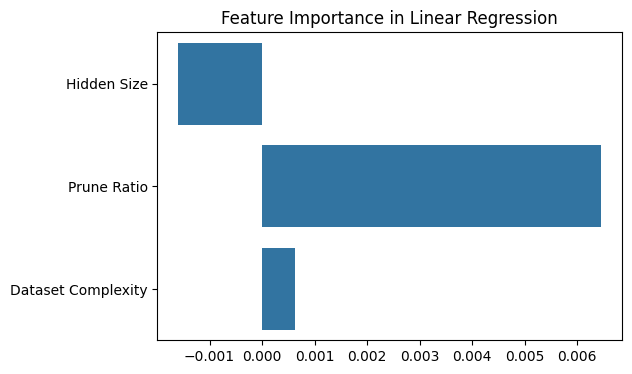

In [23]:
sk_model = LinearRegression()
sk_model.fit(X_train, y_train)


y_pred_sk = sk_model.predict(X_test)
rmse_sk = mean_squared_error(y_test, y_pred_sk, squared=False)
r2_sk = r2_score(y_test, y_pred_sk)
print(f"Scikit-learn RMSE: {rmse_sk:.4f}, R²: {r2_sk:.4f}")

plt.figure(figsize=(6, 4))
sns.barplot(x=sk_model.coef_, y=['Hidden Size', 'Prune Ratio', 'Dataset Complexity'])
plt.title('Feature Importance in Linear Regression')
plt.savefig('feature_importance.png')
plt.show()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearReg(nn.Module):
    def __init__(self, input_size=3): 
        super(LinearReg, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    def forward(self, x):
        return self.linear(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearReg().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_tensor = torch.FloatTensor(X_scaled).to(device)
y_tensor = torch.FloatTensor(y).reshape(-1, 1).to(device)

model.train()
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy()
    rmse = torch.sqrt(criterion(model(X_tensor), y_tensor)).cpu().item()
    r2 = 1 - torch.sum((y_tensor.cpu() - model(X_tensor).cpu()) ** 2) / torch.sum((y_tensor.cpu() - torch.mean(y_tensor.cpu())) ** 2)
    print(f"PyTorch RMSE: {rmse:.6f}, R²: {r2.item():.4f}")

Epoch [0/1000], Loss: 0.714082
Epoch [200/1000], Loss: 0.000290
Epoch [400/1000], Loss: 0.000070
Epoch [600/1000], Loss: 0.000070
Epoch [800/1000], Loss: 0.000070
PyTorch RMSE: 0.008338, R²: 0.3382


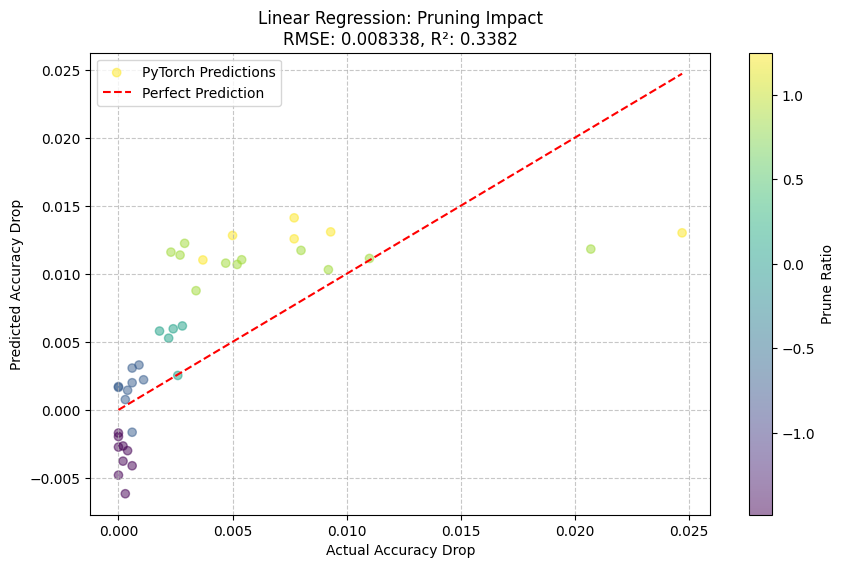

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
df_test = pd.DataFrame(X_test, columns=['hidden_size', 'prune_ratio', 'dataset_complexity'])
plt.figure(figsize=(10, 6))
scatter = plt.scatter(y_test, y_pred_test, c=df_test['prune_ratio'], label='PyTorch Predictions', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Accuracy Drop')
plt.ylabel('Predicted Accuracy Drop')
plt.title(f'Linear Regression: Pruning Impact\nRMSE: {rmse:.6f}, R²: {r2.item():.4f}')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.colorbar(scatter, label='Prune Ratio')
plt.savefig('pruning_plot.png')
plt.show()